In [47]:
from clearml import Task
import numpy as np
import random
import os
import optuna

import joblib
import pandas as pd
import optuna.visualization as vis
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from pathlib import Path
from clearml import Logger
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

from src import data_preprocessing as dp
from src import pipeline as pl
from src import feature_engineering as fe
from src.model_evaluation import evaluate
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

SEED = 42 # vẫn phải chọn random của model đấy

# Python, NumPy
random.seed(SEED)
np.random.seed(SEED) 

# Hash seed cho Python interpreter (ảnh hưởng tới dict order)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Giới hạn luồng tính toán song song (để tránh floating-point nondeterminism)
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# tạo sampler của Optuna có seed cố định
sampler = optuna.samplers.TPESampler(seed=SEED)


In [48]:
# 1. Load raw Data
df = dp.load_data(r"data\raw data\Hanoi Daily 10 years.csv")


# 2. basic preprocessing for all data set
df = dp.basic_preprocessing(df=df)

# 3. chia train, val, test (tỉ lệ 70/15/15)
target_col = 'temp'
train_size = 0.7
val_size = 0.15
n = len(df)

train_df = df.iloc[:int(train_size*n)]
val_df = df.iloc[int(train_size*n):int((train_size+val_size)*n)]
test_df = df.iloc[int((train_size+val_size)*n):]

# 4. Fit và transform trên preprocessing pipeline
pipeline1 = pl.build_preprocessing_pipeline()

# fit trên train
pipeline1.fit(train_df)

# transform 
train_processed = pipeline1.transform(train_df)
val_processed = pipeline1.transform(val_df)
test_processed = pipeline1.transform(test_df)


# Tạo feature engineering
column_lag = ['tempmax', 'tempmin', 'dew', 'humidity', 'precip',
    'precipprob', 'precipcover', 'windgust', 'windspeed',
    'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
    'pressure_temp_index', 'wind_temp_index', 'temp_range', 'dew_spread']

train_feat = fe.feature_engineering(train_processed, column= column_lag)
val_feat = fe.feature_engineering(val_processed, column= column_lag)
test_feat = fe.feature_engineering(test_processed, column= column_lag)
print(train_feat.shape)

 Loaded data with shape: (3660, 33)
Dropped column: 'description'
Dropped column: 'icon'
Dropped column: 'stations'
Dropped column: 'name'
(2562, 246)


In [49]:
# Chia X, y riêng biệt
X_train, y_train = train_feat.drop(columns=[target_col]), train_df[target_col]
X_val, y_val = val_feat.drop(columns=[target_col]), val_df[target_col]
X_test, y_test = test_feat.drop(columns=[target_col]), test_df[target_col]

print(f"Train: {X_train.shape, y_train.shape}, Val: {X_val.shape, y_val.shape}, Test: {X_test.shape, y_test.shape}")

Train: ((2562, 245), (2562,)), Val: ((549, 245), (549,)), Test: ((549, 245), (549,))


In [50]:
pipeline2 = pl.build_LGBM_feature_engineering_pipeline(top_k=30)
X_train = pipeline2.fit_transform(X= X_train, y= y_train)

In [51]:
X_val = pipeline2.transform(X= X_val)
X_test = pipeline2.transform(X= X_test)

In [52]:
X_train.columns

Index(['feelslike_lag_1', 'winddir_lag_1', 'solar_temp_index_lag_1',
       'windgust_lag_1', 'sunrise_lag_1', 'dew_spread_lag_1', 'humidity_lag_1',
       'windspeed_lag_1', 'pressure_temp_index_roll_mean_14',
       'sealevelpressure_roll_std_3', 'temp_range_lag_1',
       'visibility_roll_std_7', 'day_length_lag_1', 'wind_variability_lag_1',
       'precipcover_roll_std_3', 'windgust_roll_mean_14',
       'wind_temp_index_lag_1', 'precip_lag_1', 'rain_intensity_lag_1',
       'windgust_roll_mean_3', 'sealevelpressure_roll_std_14',
       'visibility_roll_std_3', 'cloudcover_roll_std_3',
       'solarradiation_roll_std_7', 'tempmax_roll_std_7',
       'windgust_roll_std_3', 'tempmax_roll_std_14',
       'solarradiation_roll_std_14', 'temp_range_roll_std_14', 'precip_lag_3'],
      dtype='object')

In [53]:
# chưa có feature selection để nguyên tất cả temp lag 1, 252 feature
# 1. RF
## Default
# a. Validation metrics: {'RMSE': 2.1278075895022885, 'R2': 0.8297628223226209, 'MAPE': 7.013125189028322}
# b. Test metrics: {'RMSE': 1.7168173002419687, 'R2': 0.8638144750921892, 'MAPE': 5.359437239042012}

## Best parameter
# Validation metrics: {'RMSE': 1.6388776242029133, 'R2': 0.8990089808287993, 'MAPE': 5.741406234570231}
# Test metrics: {'RMSE': 1.4337918013739446, 'R2': 0.9050150119360206, 'MAPE': 4.584963631819218}


# 2. Extra Tree
## Default
# Validation metrics: {'RMSE': 1.5501069852687441, 'R2': 0.9096531427481926, 'MAPE': 5.289823867518864}
# Test metrics: {'RMSE': 1.4094799560393934, 'R2': 0.9082088955219491, 'MAPE': 4.494487229026149}

## Best parameter
# Validation metrics: {'RMSE': 1.4981094962144423, 'R2': 0.9156127533286983, 'MAPE': 5.13799909932879}
# Test metrics: {'RMSE': 1.3558239003827515, 'R2': 0.9150644784751033, 'MAPE': 4.317549688535942}

# 3. GB
## Default
# Validation metrics: {'RMSE': 1.479398688181336, 'R2': 0.9177075178532362, 'MAPE': 5.0692414857715775}
# Test metrics: {'RMSE': 1.3534994389764416, 'R2': 0.9153554603683042, 'MAPE': 4.1845167790637126}

## Best parameter
# Validation metrics: {'RMSE': 1.5011458815829, 'R2': 0.9152703326059204, 'MAPE': 5.158944802837902}
# Test metrics: {'RMSE': 1.3430800523462543, 'R2': 0.9166536500947113, 'MAPE': 4.216884591360309}

In [54]:
from clearml import Task 

### Light GBM


In [55]:
# mỗi lần chạy xong, thì tạo task mới
# Tạo task mới trong project Temperature Forecasting

task_lgbm = Task.init(
    project_name="Temperature Forecasting",     # tên project (nếu chưa có sẽ tự tạo)
    task_name="Light GBM Optuna Tuning7", # tên task mới
    task_type=Task.TaskTypes.optimizer            # loại task (training / testing / optimizer ...)
)

# print("✅ Task created successfully!")
print("Task ID:", task_lgbm.id)

Task ID: 0208e428d4c1472fb035ebd059069c4c


In [56]:
task_lgbm = Task.get_task(task_id="0208e428d4c1472fb035ebd059069c4c")
logger_lgbm = task_lgbm.get_logger()

In [57]:
# --- A. Default Hyperparameter Model ---
model_lgbm = LGBMRegressor(
        objective='regression',
        metric='rmse',
        n_estimators=100,         
        learning_rate=0.1,         
        num_leaves=31,             
        max_depth=-1,              
        min_child_samples=20,      
        subsample=1.0,             
        colsample_bytree=1.0,      
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
model_lgbm.fit(X_train, y_train)

y_pred_val = model_lgbm.predict(X_val) 
y_pred_test = model_lgbm.predict(X_test)

In [58]:
# Lấy feature importance
importances_lgbm = model_lgbm.feature_importances_

# Tạo DataFrame hiển thị
feat_importance_lgbm = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_lgbm
}).sort_values(by='Importance', ascending=False)

#print(feat_importance_lgbm)

Text(0.5, 0, 'Importance')

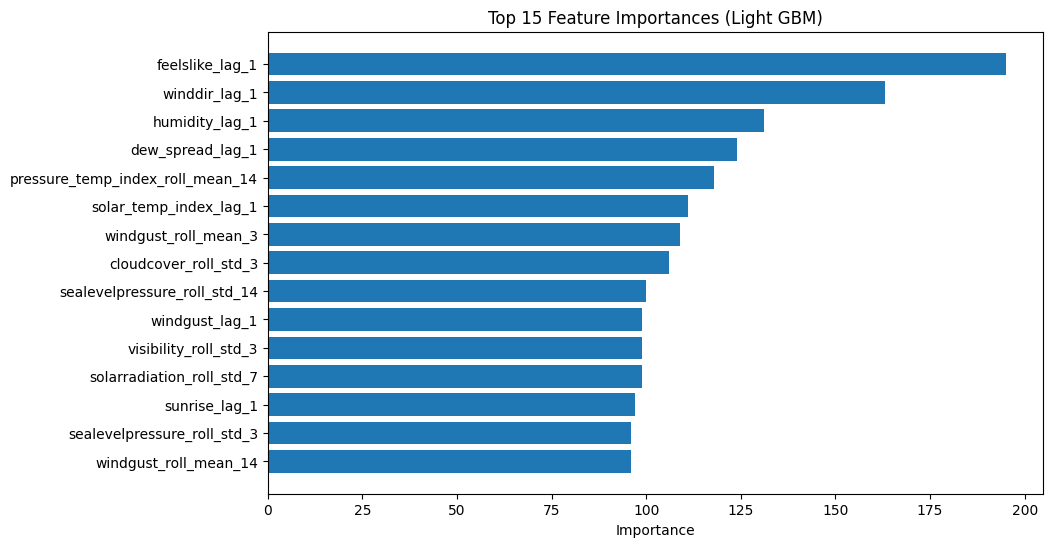

In [59]:
plt.figure(figsize=(10, 6))
plt.barh(feat_importance_lgbm['Feature'][:15], feat_importance_lgbm['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Light GBM)")
plt.xlabel("Importance")
#plt.show()

In [60]:
# Đánh giá sơ bộ trước khi tune

# 3. Evaluate on validation
defEx_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", defEx_val_metrics)

# 4. Evaluate on test
defEx_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", defEx_test_metrics)

# 5. Save model 
model_path = r'models/ExTree_model.pkl' 
joblib.dump(model_lgbm, model_path)
print(f"ExtraTree model saved to {model_path}")

# 6 Log lên ClearML
logger_lgbm.report_scalar("Default Metrics", "RMSE_val", defEx_val_metrics["RMSE"], iteration=0)
logger_lgbm.report_scalar("Default Metrics", "R2_val", defEx_val_metrics["R2"], iteration=0)
logger_lgbm.report_scalar("Default Metrics", "MAPE_val", defEx_val_metrics["MAPE"], iteration=0)
logger_lgbm.report_scalar("Default Metrics", "RMSE_test", defEx_test_metrics["RMSE"], iteration=0)
logger_lgbm.report_scalar("Default Metrics", "R2_test", defEx_test_metrics["R2"], iteration=0)
logger_lgbm.report_scalar("Default Metrics", "MAPE_test", defEx_test_metrics["MAPE"], iteration=0)


task_lgbm.upload_artifact("Default Metrics", {
    "Validation": defEx_val_metrics,
    "Test": defEx_test_metrics
})

Validation metrics: {'RMSE': np.float64(1.4675877700901645), 'R2': 0.9190162522030215, 'MAPE': np.float64(5.036462520011502)}
Test metrics: {'RMSE': np.float64(1.3649667662111598), 'R2': 0.9139151074021015, 'MAPE': np.float64(4.304491094350407)}
ExtraTree model saved to models/ExTree_model.pkl


True

In [61]:
# --- B. Hyperparameter tuning (Optuna) ---
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 15), 
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1 
    }

    cv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []

    for train_idx, val_idx in cv.split(X_train):
        X_tr, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = LGBMRegressor(**params)
        model.fit(X_tr, y_tr)
        y_pred_val_cv = model.predict(X_val_cv)

        metrics = evaluate(y_val_cv, y_pred_val_cv)
        rmse_scores.append(metrics['RMSE'])

    mean_rmse = np.mean(rmse_scores)

    logger_lgbm.report_scalar(
        title='Optuna Tuning',
        series='Trial RMSE',
        value=mean_rmse,
        iteration=trial.number
    )

    params_table = pd.DataFrame([params])
    logger_lgbm.report_table(
        title=f"Trial {trial.number} Parameters",
        series="params",
        iteration=trial.number,
        table_plot=params_table
    )

    return mean_rmse

# Chạy Optuna study
study_lgbm = optuna.create_study(
    direction='minimize',
    sampler=sampler
)
study_lgbm.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best parameters:", study_lgbm.best_trial.params)
print("Best RMSE:", study_lgbm.best_value)

[I 2025-10-24 00:22:51,161] A new study created in memory with name: no-name-a9985fbf-5ce4-4b9f-86be-b481719c63d7
Best trial: 0. Best value: 1.61046:   2%|▏         | 1/50 [00:01<00:52,  1.08s/it]

[I 2025-10-24 00:22:52,242] Trial 0 finished with value: 1.6104607144247907 and parameters: {'n_estimators': 406, 'learning_rate': 0.2536999076681772, 'num_leaves': 188, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 1.6104607144247907.


Best trial: 1. Best value: 1.48346:   4%|▍         | 2/50 [00:04<01:47,  2.23s/it]

[I 2025-10-24 00:22:55,283] Trial 1 finished with value: 1.4834585076647104 and parameters: {'n_estimators': 723, 'learning_rate': 0.010725209743171996, 'num_leaves': 249, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:   6%|▌         | 3/50 [00:04<01:10,  1.50s/it]

[I 2025-10-24 00:22:55,919] Trial 2 finished with value: 1.4888608749712893 and parameters: {'n_estimators': 460, 'learning_rate': 0.02692655251486473, 'num_leaves': 158, 'max_depth': 4, 'min_child_samples': 33, 'subsample': 0.7465447373174767, 'colsample_bytree': 0.7824279936868144, 'reg_alpha': 0.7851759613930136, 'reg_lambda': 0.19967378215835974}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:   8%|▊         | 4/50 [00:05<01:01,  1.34s/it]

[I 2025-10-24 00:22:57,006] Trial 3 finished with value: 1.519901885278316 and parameters: {'n_estimators': 539, 'learning_rate': 0.07500118950416987, 'num_leaves': 13, 'max_depth': 10, 'min_child_samples': 21, 'subsample': 0.6260206371941118, 'colsample_bytree': 0.9795542149013333, 'reg_alpha': 0.9656320330745594, 'reg_lambda': 0.8083973481164611}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  10%|█         | 5/50 [00:07<01:06,  1.48s/it]

[I 2025-10-24 00:22:58,736] Trial 4 finished with value: 1.4925929334869612 and parameters: {'n_estimators': 339, 'learning_rate': 0.013940346079873234, 'num_leaves': 176, 'max_depth': 8, 'min_child_samples': 16, 'subsample': 0.798070764044508, 'colsample_bytree': 0.6137554084460873, 'reg_alpha': 0.9093204020787821, 'reg_lambda': 0.2587799816000169}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  12%|█▏        | 6/50 [00:10<01:23,  1.91s/it]

[I 2025-10-24 00:23:01,470] Trial 5 finished with value: 1.5209547797375453 and parameters: {'n_estimators': 680, 'learning_rate': 0.028869220380495747, 'num_leaves': 134, 'max_depth': 10, 'min_child_samples': 22, 'subsample': 0.9878338511058234, 'colsample_bytree': 0.9100531293444458, 'reg_alpha': 0.9394989415641891, 'reg_lambda': 0.8948273504276488}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  14%|█▍        | 7/50 [00:11<01:07,  1.57s/it]

[I 2025-10-24 00:23:02,358] Trial 6 finished with value: 1.5396380865186683 and parameters: {'n_estimators': 618, 'learning_rate': 0.22999586428143728, 'num_leaves': 24, 'max_depth': 5, 'min_child_samples': 9, 'subsample': 0.7301321323053057, 'colsample_bytree': 0.7554709158757928, 'reg_alpha': 0.2713490317738959, 'reg_lambda': 0.8287375091519293}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  18%|█▊        | 9/50 [00:11<00:36,  1.11it/s]

[I 2025-10-24 00:23:02,824] Trial 7 finished with value: 1.5045081784517227 and parameters: {'n_estimators': 389, 'learning_rate': 0.026000059117302653, 'num_leaves': 140, 'max_depth': 4, 'min_child_samples': 82, 'subsample': 0.6298202574719083, 'colsample_bytree': 0.9947547746402069, 'reg_alpha': 0.7722447692966574, 'reg_lambda': 0.1987156815341724}. Best is trial 1 with value: 1.4834585076647104.
[I 2025-10-24 00:23:03,017] Trial 8 finished with value: 1.5218663239170813 and parameters: {'n_estimators': 55, 'learning_rate': 0.1601531217136121, 'num_leaves': 182, 'max_depth': 12, 'min_child_samples': 79, 'subsample': 0.6296178606936361, 'colsample_bytree': 0.7433862914177091, 'reg_alpha': 0.11586905952512971, 'reg_lambda': 0.8631034258755935}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  20%|██        | 10/50 [00:13<00:40,  1.02s/it]

[I 2025-10-24 00:23:04,317] Trial 9 finished with value: 1.5039931092888135 and parameters: {'n_estimators': 642, 'learning_rate': 0.030816017044468066, 'num_leaves': 18, 'max_depth': 7, 'min_child_samples': 36, 'subsample': 0.8918424713352255, 'colsample_bytree': 0.8550229885420852, 'reg_alpha': 0.8872127425763265, 'reg_lambda': 0.4722149251619493}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  22%|██▏       | 11/50 [00:15<00:54,  1.39s/it]

[I 2025-10-24 00:23:06,525] Trial 10 finished with value: 1.4926884001862715 and parameters: {'n_estimators': 970, 'learning_rate': 0.010206070557577008, 'num_leaves': 249, 'max_depth': 15, 'min_child_samples': 59, 'subsample': 0.876098829427658, 'colsample_bytree': 0.7021773835060796, 'reg_alpha': 0.40402607201864477, 'reg_lambda': 0.4792951727359478}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  24%|██▍       | 12/50 [00:17<01:06,  1.75s/it]

[I 2025-10-24 00:23:09,116] Trial 11 finished with value: 1.5001137773849065 and parameters: {'n_estimators': 909, 'learning_rate': 0.01699223047970666, 'num_leaves': 243, 'max_depth': 14, 'min_child_samples': 45, 'subsample': 0.7370063974951027, 'colsample_bytree': 0.6859627191294981, 'reg_alpha': 0.6071842740332256, 'reg_lambda': 0.009046927318156123}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  26%|██▌       | 13/50 [00:18<00:53,  1.45s/it]

[I 2025-10-24 00:23:09,863] Trial 12 finished with value: 1.5426568913692917 and parameters: {'n_estimators': 805, 'learning_rate': 0.058261802534285465, 'num_leaves': 79, 'max_depth': 3, 'min_child_samples': 57, 'subsample': 0.715850780023381, 'colsample_bytree': 0.815848042721119, 'reg_alpha': 0.5992087187997686, 'reg_lambda': 0.2944068495666103}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  28%|██▊       | 14/50 [00:19<00:41,  1.14s/it]

[I 2025-10-24 00:23:10,308] Trial 13 finished with value: 1.5131198376403043 and parameters: {'n_estimators': 169, 'learning_rate': 0.01892380376353781, 'num_leaves': 84, 'max_depth': 6, 'min_child_samples': 36, 'subsample': 0.7987586652315627, 'colsample_bytree': 0.6966219731921359, 'reg_alpha': 0.3473443561556252, 'reg_lambda': 0.64208794318194}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  30%|███       | 15/50 [00:21<00:55,  1.60s/it]

[I 2025-10-24 00:23:12,955] Trial 14 finished with value: 1.5215299596689715 and parameters: {'n_estimators': 744, 'learning_rate': 0.04424937591236206, 'num_leaves': 214, 'max_depth': 13, 'min_child_samples': 35, 'subsample': 0.6939187182384499, 'colsample_bytree': 0.796840732144714, 'reg_alpha': 0.12476602449473986, 'reg_lambda': 0.09086840375111392}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  32%|███▏      | 16/50 [00:22<00:50,  1.48s/it]

[I 2025-10-24 00:23:14,161] Trial 15 finished with value: 1.50526259320585 and parameters: {'n_estimators': 454, 'learning_rate': 0.010433904133257729, 'num_leaves': 97, 'max_depth': 12, 'min_child_samples': 67, 'subsample': 0.7673635839576047, 'colsample_bytree': 0.8674582886269184, 'reg_alpha': 0.6705451426048863, 'reg_lambda': 0.43451435782595793}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  34%|███▍      | 17/50 [00:25<00:56,  1.72s/it]

[I 2025-10-24 00:23:16,425] Trial 16 finished with value: 1.510530556732527 and parameters: {'n_estimators': 843, 'learning_rate': 0.08801819602632835, 'num_leaves': 216, 'max_depth': 8, 'min_child_samples': 5, 'subsample': 0.8720139949842398, 'colsample_bytree': 0.6512694504817759, 'reg_alpha': 0.47866936071859034, 'reg_lambda': 0.3583902847905419}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  36%|███▌      | 18/50 [00:26<00:47,  1.47s/it]

[I 2025-10-24 00:23:17,330] Trial 17 finished with value: 1.4924535800962635 and parameters: {'n_estimators': 252, 'learning_rate': 0.042055725241708065, 'num_leaves': 153, 'max_depth': 12, 'min_child_samples': 48, 'subsample': 0.6732315708885339, 'colsample_bytree': 0.7544273033878155, 'reg_alpha': 0.23951225471837512, 'reg_lambda': 0.6556498190600932}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  38%|███▊      | 19/50 [00:26<00:37,  1.22s/it]

[I 2025-10-24 00:23:17,956] Trial 18 finished with value: 1.4931152391586366 and parameters: {'n_estimators': 591, 'learning_rate': 0.021069676640142868, 'num_leaves': 54, 'max_depth': 3, 'min_child_samples': 28, 'subsample': 0.8366070683982902, 'colsample_bytree': 0.7976507673645237, 'reg_alpha': 0.6914344988956265, 'reg_lambda': 0.1643967376099857}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  40%|████      | 20/50 [00:27<00:34,  1.15s/it]

[I 2025-10-24 00:23:18,932] Trial 19 finished with value: 1.4942555223216658 and parameters: {'n_estimators': 488, 'learning_rate': 0.013991038367899857, 'num_leaves': 107, 'max_depth': 15, 'min_child_samples': 68, 'subsample': 0.7642025555264566, 'colsample_bytree': 0.6567104234717263, 'reg_alpha': 0.45366053575028714, 'reg_lambda': 0.3534692325095147}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  42%|████▏     | 21/50 [00:28<00:32,  1.12s/it]

[I 2025-10-24 00:23:19,994] Trial 20 finished with value: 1.6026076903541817 and parameters: {'n_estimators': 742, 'learning_rate': 0.11005791941043674, 'num_leaves': 221, 'max_depth': 6, 'min_child_samples': 95, 'subsample': 0.9614035607563236, 'colsample_bytree': 0.9177821035896214, 'reg_alpha': 0.011620961627553272, 'reg_lambda': 0.9938427850497087}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 1. Best value: 1.48346:  44%|████▍     | 22/50 [00:29<00:28,  1.02s/it]

[I 2025-10-24 00:23:20,767] Trial 21 finished with value: 1.5032492652736371 and parameters: {'n_estimators': 279, 'learning_rate': 0.04285150252074264, 'num_leaves': 154, 'max_depth': 12, 'min_child_samples': 47, 'subsample': 0.6715011565469081, 'colsample_bytree': 0.7431809610203663, 'reg_alpha': 0.2895492452060503, 'reg_lambda': 0.6466669471993522}. Best is trial 1 with value: 1.4834585076647104.


Best trial: 22. Best value: 1.47968:  46%|████▌     | 23/50 [00:30<00:24,  1.10it/s]

[I 2025-10-24 00:23:21,437] Trial 22 finished with value: 1.4796785969709965 and parameters: {'n_estimators': 229, 'learning_rate': 0.037073700845267156, 'num_leaves': 155, 'max_depth': 11, 'min_child_samples': 44, 'subsample': 0.6730396214365393, 'colsample_bytree': 0.7267340845030492, 'reg_alpha': 0.21153958273338241, 'reg_lambda': 0.7242630922111837}. Best is trial 22 with value: 1.4796785969709965.


Best trial: 22. Best value: 1.47968:  48%|████▊     | 24/50 [00:30<00:22,  1.18it/s]

[I 2025-10-24 00:23:22,142] Trial 23 finished with value: 1.484832474610639 and parameters: {'n_estimators': 148, 'learning_rate': 0.03476945195940975, 'num_leaves': 199, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.7024138525502907, 'colsample_bytree': 0.7207299397203465, 'reg_alpha': 0.17392714953607313, 'reg_lambda': 0.7510882509824127}. Best is trial 22 with value: 1.4796785969709965.


Best trial: 22. Best value: 1.47968:  50%|█████     | 25/50 [00:31<00:17,  1.39it/s]

[I 2025-10-24 00:23:22,549] Trial 24 finished with value: 1.4852927257927562 and parameters: {'n_estimators': 71, 'learning_rate': 0.06682224013041096, 'num_leaves': 201, 'max_depth': 11, 'min_child_samples': 28, 'subsample': 0.6089145049038844, 'colsample_bytree': 0.7002347311595115, 'reg_alpha': 0.1696233037043374, 'reg_lambda': 0.7414450168878227}. Best is trial 22 with value: 1.4796785969709965.


Best trial: 25. Best value: 1.47459:  52%|█████▏    | 26/50 [00:31<00:16,  1.47it/s]

[I 2025-10-24 00:23:23,142] Trial 25 finished with value: 1.4745853836118137 and parameters: {'n_estimators': 181, 'learning_rate': 0.03535541139245488, 'num_leaves': 240, 'max_depth': 13, 'min_child_samples': 42, 'subsample': 0.7010167689421148, 'colsample_bytree': 0.6605184319353712, 'reg_alpha': 0.020992816677700032, 'reg_lambda': 0.5641493403440335}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  54%|█████▍    | 27/50 [00:32<00:17,  1.34it/s]

[I 2025-10-24 00:23:24,039] Trial 26 finished with value: 1.545898870826281 and parameters: {'n_estimators': 220, 'learning_rate': 0.11277661172347543, 'num_leaves': 234, 'max_depth': 14, 'min_child_samples': 42, 'subsample': 0.6619343009332945, 'colsample_bytree': 0.6506090757484941, 'reg_alpha': 0.025328595278902633, 'reg_lambda': 0.5535387686722112}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  56%|█████▌    | 28/50 [00:33<00:16,  1.30it/s]

[I 2025-10-24 00:23:24,871] Trial 27 finished with value: 1.5112784579621215 and parameters: {'n_estimators': 318, 'learning_rate': 0.05020671455211381, 'num_leaves': 234, 'max_depth': 13, 'min_child_samples': 55, 'subsample': 0.6891855650014052, 'colsample_bytree': 0.6585319947526904, 'reg_alpha': 0.08067831169843259, 'reg_lambda': 0.525578146814522}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  58%|█████▊    | 29/50 [00:34<00:14,  1.46it/s]

[I 2025-10-24 00:23:25,354] Trial 28 finished with value: 1.5311142955169852 and parameters: {'n_estimators': 142, 'learning_rate': 0.02256006021358721, 'num_leaves': 254, 'max_depth': 14, 'min_child_samples': 41, 'subsample': 0.6469282854040203, 'colsample_bytree': 0.6160280931301652, 'reg_alpha': 0.3648858887172245, 'reg_lambda': 0.7124947825754071}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  60%|██████    | 30/50 [00:36<00:23,  1.16s/it]

[I 2025-10-24 00:23:27,620] Trial 29 finished with value: 1.4938100272182873 and parameters: {'n_estimators': 376, 'learning_rate': 0.0140047954012614, 'num_leaves': 168, 'max_depth': 11, 'min_child_samples': 16, 'subsample': 0.6010603166303072, 'colsample_bytree': 0.6036691172680716, 'reg_alpha': 0.20885447300979176, 'reg_lambda': 0.5769383079445419}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  62%|██████▏   | 31/50 [00:37<00:22,  1.21s/it]

[I 2025-10-24 00:23:28,945] Trial 30 finished with value: 1.5201149842220305 and parameters: {'n_estimators': 547, 'learning_rate': 0.037161448721430596, 'num_leaves': 195, 'max_depth': 9, 'min_child_samples': 53, 'subsample': 0.773536315881101, 'colsample_bytree': 0.7230189679414286, 'reg_alpha': 0.3132109054209895, 'reg_lambda': 0.3959237727783301}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  64%|██████▍   | 32/50 [00:38<00:18,  1.05s/it]

[I 2025-10-24 00:23:29,640] Trial 31 finished with value: 1.4803314588039513 and parameters: {'n_estimators': 140, 'learning_rate': 0.03553793604183132, 'num_leaves': 204, 'max_depth': 11, 'min_child_samples': 27, 'subsample': 0.7075384777286414, 'colsample_bytree': 0.6776752050027633, 'reg_alpha': 0.18784011905209202, 'reg_lambda': 0.7366197334645432}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  66%|██████▌   | 33/50 [00:39<00:17,  1.04s/it]

[I 2025-10-24 00:23:30,636] Trial 32 finished with value: 1.4971119431075646 and parameters: {'n_estimators': 203, 'learning_rate': 0.058917774302488846, 'num_leaves': 231, 'max_depth': 13, 'min_child_samples': 25, 'subsample': 0.7151142223753031, 'colsample_bytree': 0.6745650004020675, 'reg_alpha': 0.0689938001759009, 'reg_lambda': 0.6008984236501816}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  68%|██████▊   | 34/50 [00:39<00:13,  1.18it/s]

[I 2025-10-24 00:23:31,031] Trial 33 finished with value: 1.5569280952976716 and parameters: {'n_estimators': 107, 'learning_rate': 0.024861422417896066, 'num_leaves': 210, 'max_depth': 9, 'min_child_samples': 38, 'subsample': 0.6508316782774582, 'colsample_bytree': 0.6718262986403243, 'reg_alpha': 0.18558974949022322, 'reg_lambda': 0.6989848191124235}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  70%|███████   | 35/50 [00:41<00:16,  1.10s/it]

[I 2025-10-24 00:23:32,711] Trial 34 finished with value: 1.5084957547328652 and parameters: {'n_estimators': 283, 'learning_rate': 0.03466826347048089, 'num_leaves': 186, 'max_depth': 10, 'min_child_samples': 14, 'subsample': 0.6850351030654552, 'colsample_bytree': 0.6342778992639416, 'reg_alpha': 0.11962965031970402, 'reg_lambda': 0.9136015492560878}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  72%|███████▏  | 36/50 [00:42<00:15,  1.09s/it]

[I 2025-10-24 00:23:33,776] Trial 35 finished with value: 1.4992230119478838 and parameters: {'n_estimators': 200, 'learning_rate': 0.017372632913416005, 'num_leaves': 165, 'max_depth': 11, 'min_child_samples': 20, 'subsample': 0.746765247869304, 'colsample_bytree': 0.7198771767246773, 'reg_alpha': 0.24675016435737734, 'reg_lambda': 0.7918619726908254}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  74%|███████▍  | 37/50 [00:43<00:11,  1.13it/s]

[I 2025-10-24 00:23:34,185] Trial 36 finished with value: 1.5240977697325144 and parameters: {'n_estimators': 108, 'learning_rate': 0.09136171314744959, 'num_leaves': 120, 'max_depth': 13, 'min_child_samples': 31, 'subsample': 0.8249574951505665, 'colsample_bytree': 0.6367458486612505, 'reg_alpha': 0.41228179983917546, 'reg_lambda': 0.5060944618370891}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  76%|███████▌  | 38/50 [00:44<00:13,  1.11s/it]

[I 2025-10-24 00:23:35,827] Trial 37 finished with value: 1.5023607416140077 and parameters: {'n_estimators': 424, 'learning_rate': 0.02819782070565746, 'num_leaves': 256, 'max_depth': 10, 'min_child_samples': 23, 'subsample': 0.7168280614849236, 'colsample_bytree': 0.77459627385957, 'reg_alpha': 0.542143855793352, 'reg_lambda': 0.6753144921494529}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  78%|███████▊  | 39/50 [00:46<00:15,  1.40s/it]

[I 2025-10-24 00:23:37,917] Trial 38 finished with value: 1.5156889403521832 and parameters: {'n_estimators': 313, 'learning_rate': 0.04925889576573655, 'num_leaves': 228, 'max_depth': 14, 'min_child_samples': 12, 'subsample': 0.6318672713332886, 'colsample_bytree': 0.6279726021666024, 'reg_alpha': 0.039713225358783626, 'reg_lambda': 0.7848943834379494}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  80%|████████  | 40/50 [00:47<00:12,  1.26s/it]

[I 2025-10-24 00:23:38,824] Trial 39 finished with value: 1.630643867384585 and parameters: {'n_estimators': 378, 'learning_rate': 0.2161512504601447, 'num_leaves': 141, 'max_depth': 12, 'min_child_samples': 62, 'subsample': 0.6533163615930541, 'colsample_bytree': 0.6774299510005038, 'reg_alpha': 0.14203205945160818, 'reg_lambda': 0.6215099220696408}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  82%|████████▏ | 41/50 [00:49<00:12,  1.38s/it]

[I 2025-10-24 00:23:40,507] Trial 40 finished with value: 1.487243098086736 and parameters: {'n_estimators': 687, 'learning_rate': 0.011840161496799036, 'num_leaves': 178, 'max_depth': 8, 'min_child_samples': 50, 'subsample': 0.7446370238715672, 'colsample_bytree': 0.7300725571610435, 'reg_alpha': 0.317820940294554, 'reg_lambda': 0.8340023920549832}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  84%|████████▍ | 42/50 [00:50<00:10,  1.31s/it]

[I 2025-10-24 00:23:41,648] Trial 41 finished with value: 1.4846995242270917 and parameters: {'n_estimators': 148, 'learning_rate': 0.03429214607459629, 'num_leaves': 192, 'max_depth': 11, 'min_child_samples': 30, 'subsample': 0.6998162588973983, 'colsample_bytree': 0.7711039538668426, 'reg_alpha': 0.21216483471668718, 'reg_lambda': 0.7500573717641517}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  86%|████████▌ | 43/50 [00:54<00:14,  2.06s/it]

[I 2025-10-24 00:23:45,456] Trial 42 finished with value: 1.52219728927763 and parameters: {'n_estimators': 103, 'learning_rate': 0.030474757454922525, 'num_leaves': 203, 'max_depth': 9, 'min_child_samples': 25, 'subsample': 0.706113634919691, 'colsample_bytree': 0.8330663743696199, 'reg_alpha': 0.2322994537019237, 'reg_lambda': 0.91738985170924}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  88%|████████▊ | 44/50 [00:55<00:11,  1.93s/it]

[I 2025-10-24 00:23:47,080] Trial 43 finished with value: 1.7265598758986922 and parameters: {'n_estimators': 52, 'learning_rate': 0.036543426726893605, 'num_leaves': 239, 'max_depth': 11, 'min_child_samples': 42, 'subsample': 0.6797564736856957, 'colsample_bytree': 0.7697846231481719, 'reg_alpha': 0.08667749331269929, 'reg_lambda': 0.7491689593491082}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  90%|█████████ | 45/50 [01:01<00:15,  3.16s/it]

[I 2025-10-24 00:23:53,102] Trial 44 finished with value: 1.5053604915137775 and parameters: {'n_estimators': 244, 'learning_rate': 0.06557427886289512, 'num_leaves': 192, 'max_depth': 10, 'min_child_samples': 33, 'subsample': 0.722028599358516, 'colsample_bytree': 0.7061812135575102, 'reg_alpha': 0.27993182156272417, 'reg_lambda': 0.5459137021222557}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  92%|█████████▏| 46/50 [01:12<00:21,  5.34s/it]

[I 2025-10-24 00:24:03,528] Trial 45 finished with value: 1.4899848767691704 and parameters: {'n_estimators': 187, 'learning_rate': 0.02415136003021407, 'num_leaves': 174, 'max_depth': 13, 'min_child_samples': 18, 'subsample': 0.6391679125192807, 'colsample_bytree': 0.7431501643288505, 'reg_alpha': 0.3694439082604318, 'reg_lambda': 0.44784018967689754}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  94%|█████████▍| 47/50 [01:15<00:14,  4.78s/it]

[I 2025-10-24 00:24:07,010] Trial 46 finished with value: 1.5661177273121911 and parameters: {'n_estimators': 130, 'learning_rate': 0.020514168102375326, 'num_leaves': 245, 'max_depth': 15, 'min_child_samples': 39, 'subsample': 0.6175477443055092, 'colsample_bytree': 0.6852050227594195, 'reg_alpha': 0.19237441222958604, 'reg_lambda': 0.8587148304326301}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  96%|█████████▌| 48/50 [01:37<00:19,  9.99s/it]

[I 2025-10-24 00:24:29,144] Trial 47 finished with value: 1.5247128745933904 and parameters: {'n_estimators': 994, 'learning_rate': 0.029920004761043277, 'num_leaves': 221, 'max_depth': 12, 'min_child_samples': 45, 'subsample': 0.7838554919115773, 'colsample_bytree': 0.7610940678844151, 'reg_alpha': 0.13955135488086617, 'reg_lambda': 0.7002727619671392}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459:  98%|█████████▊| 49/50 [01:41<00:08,  8.13s/it]

[I 2025-10-24 00:24:32,963] Trial 48 finished with value: 1.5680688990275091 and parameters: {'n_estimators': 164, 'learning_rate': 0.01595620166081445, 'num_leaves': 144, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.7378557993891562, 'colsample_bytree': 0.818167498830793, 'reg_alpha': 0.2582325309229212, 'reg_lambda': 0.5888787075468495}. Best is trial 25 with value: 1.4745853836118137.


Best trial: 25. Best value: 1.47459: 100%|██████████| 50/50 [01:43<00:00,  2.07s/it]

[I 2025-10-24 00:24:34,620] Trial 49 finished with value: 1.5086566336123945 and parameters: {'n_estimators': 343, 'learning_rate': 0.04765383166239607, 'num_leaves': 182, 'max_depth': 12, 'min_child_samples': 35, 'subsample': 0.6654825503650624, 'colsample_bytree': 0.7840538437519955, 'reg_alpha': 0.05980591981642194, 'reg_lambda': 0.9614536015606393}. Best is trial 25 with value: 1.4745853836118137.
Best parameters: {'n_estimators': 181, 'learning_rate': 0.03535541139245488, 'num_leaves': 240, 'max_depth': 13, 'min_child_samples': 42, 'subsample': 0.7010167689421148, 'colsample_bytree': 0.6605184319353712, 'reg_alpha': 0.020992816677700032, 'reg_lambda': 0.5641493403440335}
Best RMSE: 1.4745853836118137


In [62]:
# === 4 Log kết quả tổng hợp ===
task_lgbm.upload_artifact("Best Parameters", study_lgbm.best_trial.params)

# Fit lại mô hình với best params
best_model_ex = LGBMRegressor(**study_lgbm.best_trial.params)
best_model_ex.fit(X_train, y_train)

# Predict
y_pred_val = best_model_ex.predict(X_val)
y_pred_test = best_model_ex.predict(X_test)

# Evaluate on validation
bestEx_val_metrics = evaluate(y_val, y_pred_val)
print("Validation metrics:", bestEx_val_metrics)

# Evaluate on test
bestEx_test_metrics = evaluate(y_test, y_pred_test)
print("Test metrics:", bestEx_test_metrics)


# 6 Log lên ClearML
logger_lgbm.report_scalar("Best Metrics", "RMSE_val", bestEx_val_metrics["RMSE"], iteration=0)
logger_lgbm.report_scalar("Best Metrics", "R2_val", bestEx_val_metrics["R2"], iteration=0)
logger_lgbm.report_scalar("Best Metrics", "MAPE_val", bestEx_val_metrics["MAPE"], iteration=0)
logger_lgbm.report_scalar("Best Metrics", "RMSE_test", bestEx_test_metrics["RMSE"], iteration=0)
logger_lgbm.report_scalar("Best Metrics", "R2_test", bestEx_test_metrics["R2"], iteration=0)
logger_lgbm.report_scalar("Best Metrics", "MAPE_test", bestEx_test_metrics["MAPE"], iteration=0)


# Upload artifact tổng hợp
task_lgbm.upload_artifact("Best Metrics", {
    "Validation": bestEx_val_metrics,
    "Test": bestEx_test_metrics
})


# Save & upload model
model_path = r'models/Tuning_LGBM_model.pkl' 
joblib.dump(best_model_ex, model_path)
print(f"LGBM model saved to {model_path}")
task_lgbm.upload_artifact("Best Model", model_path)

Validation metrics: {'RMSE': np.float64(1.4644891119109276), 'R2': 0.9193578686157625, 'MAPE': np.float64(5.006440674737391)}
Test metrics: {'RMSE': np.float64(1.3484958628505441), 'R2': 0.915980126397003, 'MAPE': np.float64(4.281489655120908)}
LGBM model saved to models/Tuning_LGBM_model.pkl


True

In [63]:
# === 6️ Vẽ biểu đồ RMSE theo trial  ===
fig2 = plt.figure(figsize=(7, 4))
plt.plot([t.value for t in study_lgbm.trials])
plt.xlabel("Trial")
plt.ylabel("RMSE")
plt.title("Optuna RMSE per Trial")

logger_lgbm.report_matplotlib_figure(
    title="Optuna Performance", 
    series="RMSE Curve", 
    figure=fig2,
    iteration=len(study_lgbm.trials)
)
plt.close(fig2)


In [64]:
vis.plot_parallel_coordinate(study_lgbm)

In [65]:
vis.plot_slice(study=study_lgbm)

In [66]:
vis.plot_param_importances(study=study_lgbm)

In [ ]:
task_lgbm.close()

: 